# STAT207 Final Project - Toward Early Detection: A Model for Student Depression Risk

Sahil Sangani,
Jonathan Tang,
Ruosi Hu,
Vera Feng

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 1. Introduction

#### Primary Research Goal

Build a predictive model that will effectively `predict the presence of Depression of students for new datasets.`

#### Secondary Research Goal

Ideally, we would like for our chosen model to also yield reliable interpretative insights about the nature of the relationship between the variables in the dataset.

#### Research Motivation

This predictive model uses the categorical variables (Sleep Duration, Dietary Habits, Gender), and the numerical variables (Acedemic Pressure, Study Satisfication, Age, Study Hours, Financial Stress) to predict whether or not a student has Depression. Someone would be motivated to build a model like this because they would be able to predict whether or not a student is feeling Depression by doing a simple survey. This model would be useful for many educational purposes. For example, a high school could require their Teachers to use this model to do a check on their students for mental health each semester, and possibly hold in-person conversations to those who are predicted to have depression. The people using this model would most likely desire to have more 'negatives' (No Depression) than the 'positives' (Depression), because for example, it's important that educators have their students to have good mental healths.

#### Citation
* American Academy of Pediatrics. (2022, November 15). Supporting students with depression in school. Home. https://www.aap.org/en/patient-care/school-health/mental-health-in-schools/supporting-students-with-depression-in-school/?srsltid=AfmBOorhCOW_Vbe3TI7HiNoWkdGVHB6xw6wE6JGoNaSougkQo2lSi97r 
* Lochrie, A. S. (Ed.). (2022, April). Depression Factsheet (for Schools) (for parents) | nemours kidshealth. KidsHealth. https://kidshealth.org/en/parents/depression-factsheet.html

## 2. Dataset Discussion

Our team got the dataset from Kaggle [Depession Student Dataset](https://www.kaggle.com/datasets/ikynahidwin/depression-student-dataset), downloaded on Apr 22, 2025. The author filtered the rows correlated to students from the [original larger dataset](https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis), whose results came from a survey. 

Each row includes multiple information about the participant, such as gender, age, academic pressure(range from 1.0 - 5.0), etc. With all the prior status, the last column tells if the participant actually has depression. So far, we think this dataset currently include sufficient and relevant information of students and the problem of depression with both categorical and numerical explanatory variables.

To our intended audience (students and teachers), our results can provide them better insights that if a student suffers from depression based on their status for the conditions. Our answers can serve as a basic measurement reference and can be the shallowest step for our audience to recognize their depression problems. The actions they take later may include seeking/suggesting someone to seek a counselor or go to the hospital for medical treatment.

In [2]:
df = pd.read_csv('Depression Student Dataset.csv')
df = df.drop(['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], axis=1)
df.head()

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Study Hours,Financial Stress,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,9,2,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,7,1,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,10,4,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,7,2,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,4,2,No


In [3]:
df.shape[0]

502

The response variable our team intend to use is **Depression**. This column is tightly connected to all the information and status given in the prior columns, and it would be the most helpful to our audience.  

For the explanatory variables, we will include **Gender**, **Age**, **Academic Pressure**, **Study Satisfaction**, **Sleep Duration**, **Dietary**, **Study Hours**, **Financial Stress**. We think these are conditions that related to the depression problem of students and can actually help make our prediction results more accurate and valuable. We exclude the two Yes/No questions (**Have you ever had suicidal thoughts ?** and **Family History of Mental Illness**), because we think the Yes/No answers are too general without taking their specific cases and contexts into account, which might be misleading for our final results. 

## 3. Data Cleaning

The dataset does not contain any explicit missing values, as there are no NaN entries. Additionally, there are no implicit missing values, since all columns have the expected data types and all categorical variable levels are appropriate within the context of the dataset. No outliers were detected, as confirmed by the box plots and pair plots. In conclusion, the dataset required no additional data cleaning, and no rows were dropped during this process.

In [4]:
df.isna().sum()

Gender                0
Age                   0
Academic Pressure     0
Study Satisfaction    0
Sleep Duration        0
Dietary Habits        0
Study Hours           0
Financial Stress      0
Depression            0
dtype: int64

In [5]:
df.dtypes

Gender                 object
Age                     int64
Academic Pressure     float64
Study Satisfaction    float64
Sleep Duration         object
Dietary Habits         object
Study Hours             int64
Financial Stress        int64
Depression             object
dtype: object

In [6]:
for col in df.columns:
    print(col, df[col].unique())

Gender ['Male' 'Female']
Age [28 25 23 31 19 34 20 33 24 21 29 30 32 26 22 27 18]
Academic Pressure [2. 4. 1. 5. 3.]
Study Satisfaction [4. 5. 3. 2. 1.]
Sleep Duration ['7-8 hours' '5-6 hours' 'More than 8 hours' 'Less than 5 hours']
Dietary Habits ['Moderate' 'Healthy' 'Unhealthy']
Study Hours [ 9  7 10  4  1  6  3 11  2 12  8  0  5]
Financial Stress [2 1 4 3 5]
Depression ['No' 'Yes']


<Axes: >

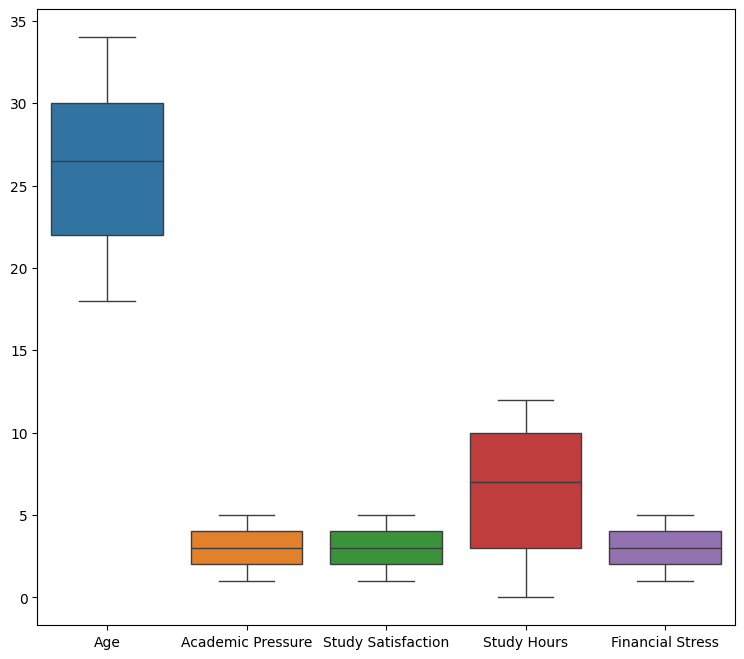

In [7]:
plt.figure(figsize=(9,8))
sns.boxplot(data=df)

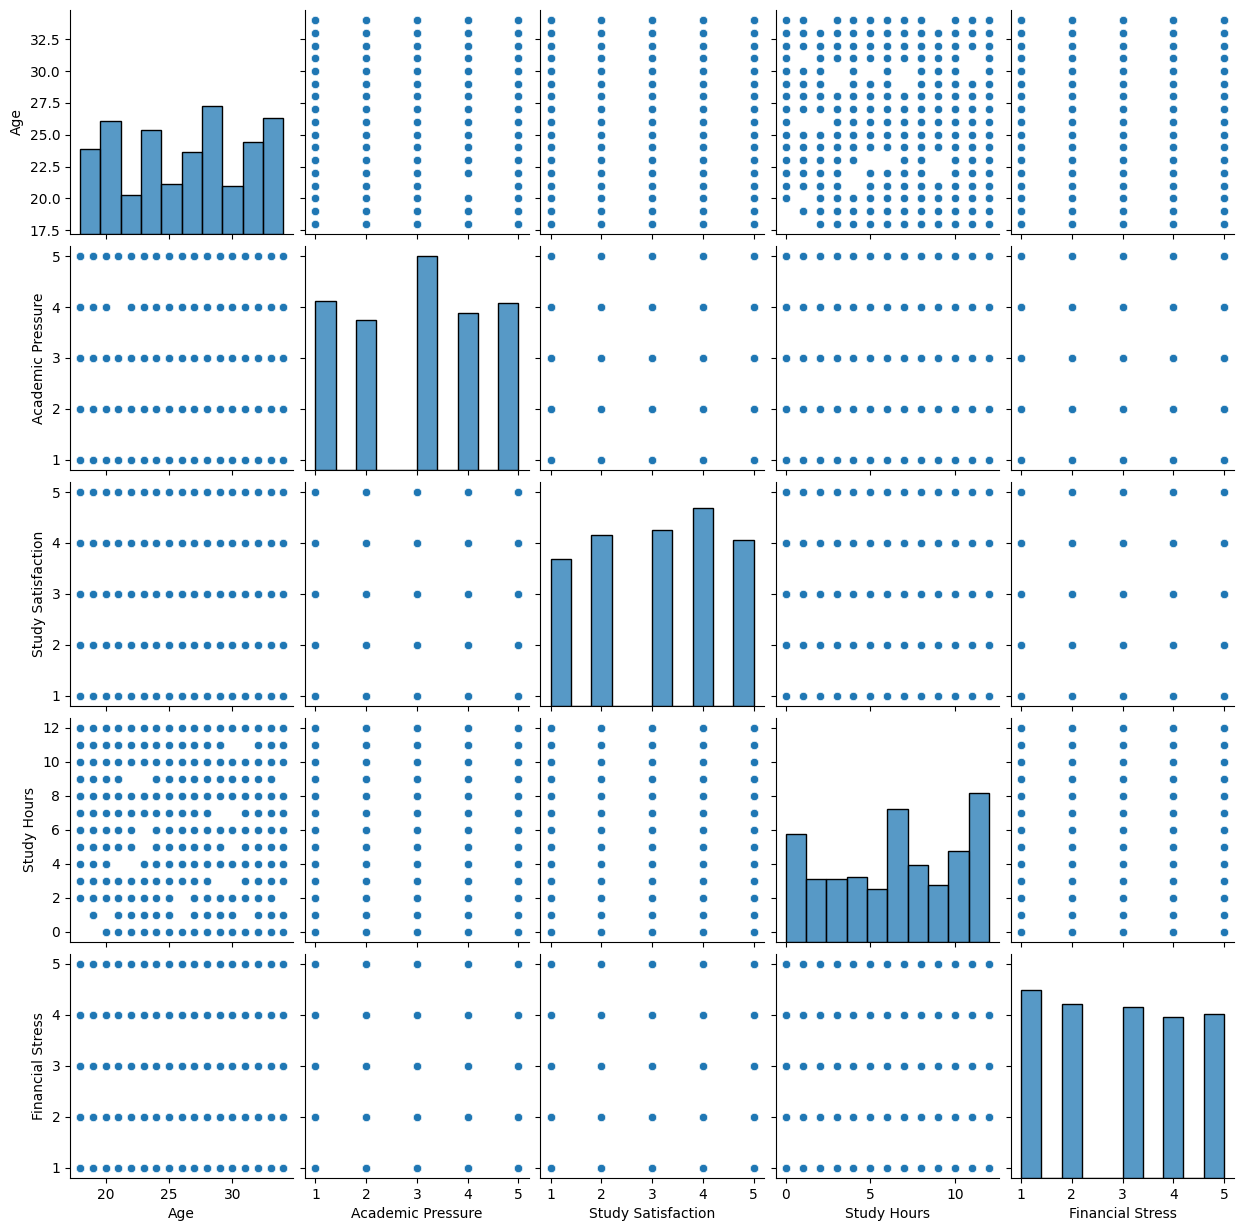

In [8]:
sns.pairplot(df)

## 4. Preliminary Analysis:

Based on the visualizations, Dietary Habits shows a strong relationship with depression status, while Sleep Duration appears moderately related, and Gender shows little to no association. Among the numerical explanatory variables, Academic Pressure stands out with a strong relationship to depression status. Financial Stress and Study Satisfaction show moderate associations, whereas Age and Study Hours appear weakly related.

In [9]:
categorical_exp_vars = ['Gender', 'Sleep Duration', 'Dietary Habits']
numerical_exp_vars = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']

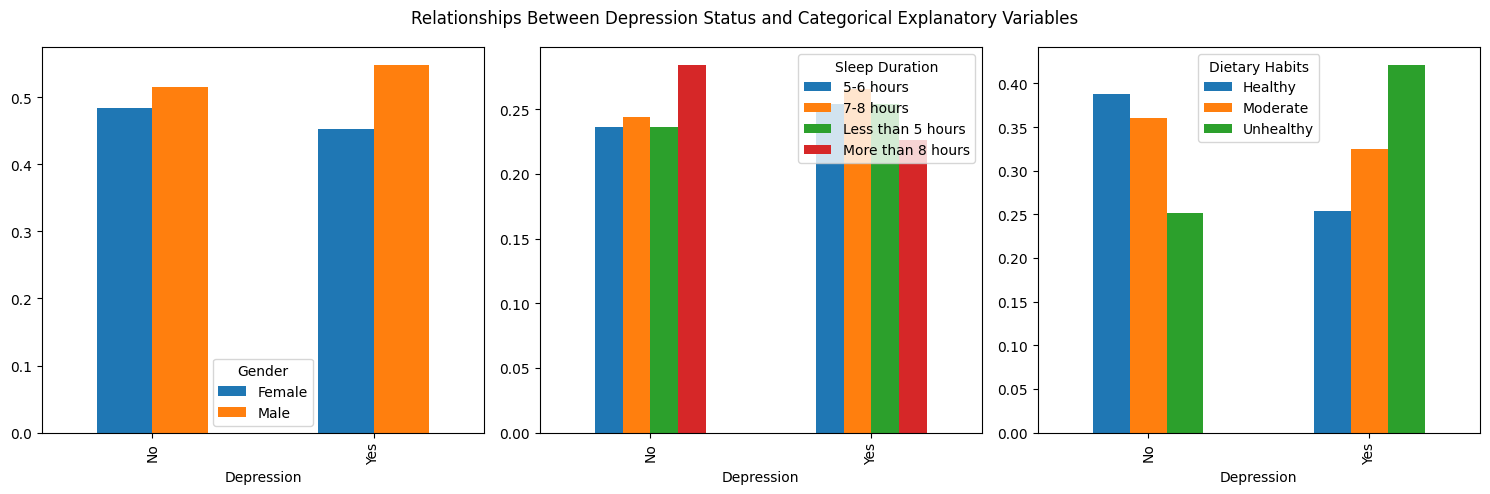

In [10]:
plt.figure(figsize=(15,5))
plt.suptitle('Relationships Between Depression Status and Categorical Explanatory Variables')
n=1
for col in categorical_exp_vars:
    ax = plt.subplot(1,3,n)
    temp = pd.crosstab(df['Depression'], df[col], normalize='index')
    temp.plot.bar(ax=ax)
    n+=1

plt.tight_layout()
plt.show()

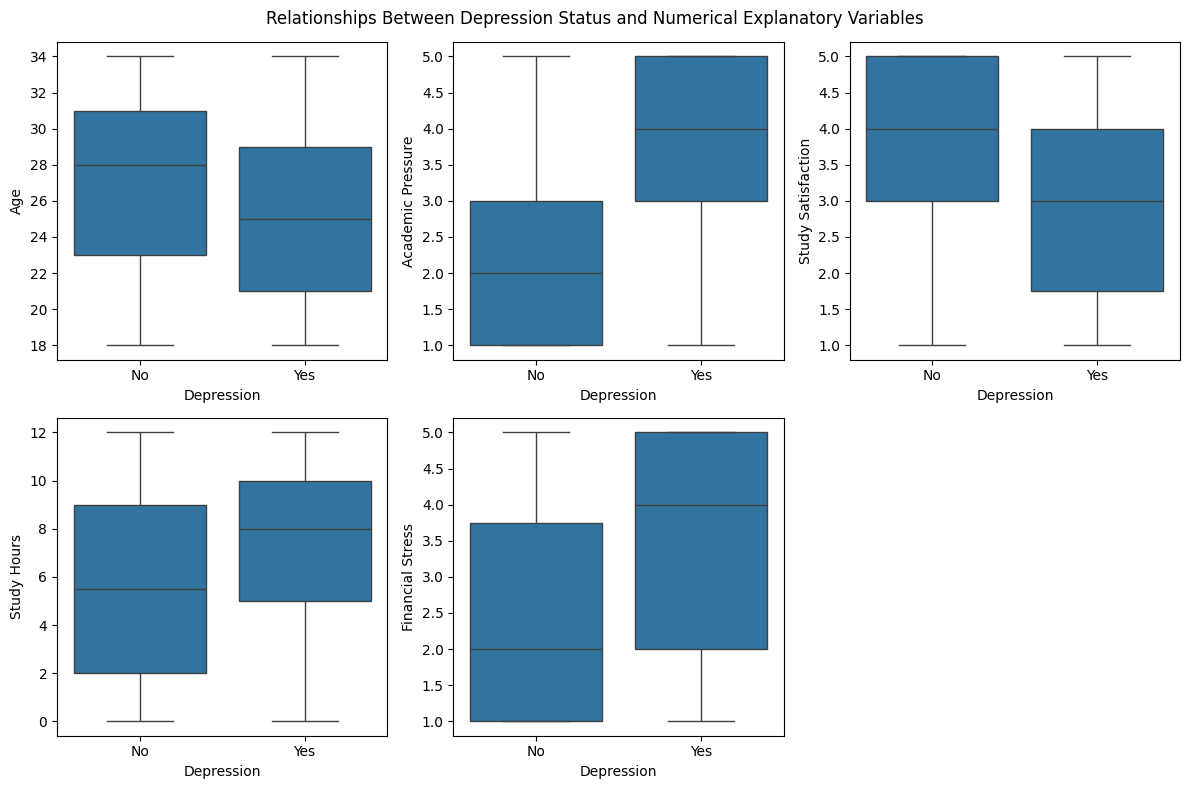

In [11]:
plt.figure(figsize=(12,8))
plt.suptitle('Relationships Between Depression Status and Numerical Explanatory Variables')
n = 1
for col in numerical_exp_vars:
    plt.subplot(2,3,n)
    sns.boxplot(x='Depression', y=col, data=df)
    n+=1

plt.tight_layout()
plt.show()

The following plots show the relationships between pairs of explanatory variables. The correlations between numerical explanatory variables appear weak, possibly due to their discrete nature. Similarly, the relationships between numerical and categorical variables are weak, as indicated by significant overlap in the boxplots. In contrast, relationships between pairs of categorical variables are more notable—bar charts reveal moderate associations, with differing frequencies across categories.

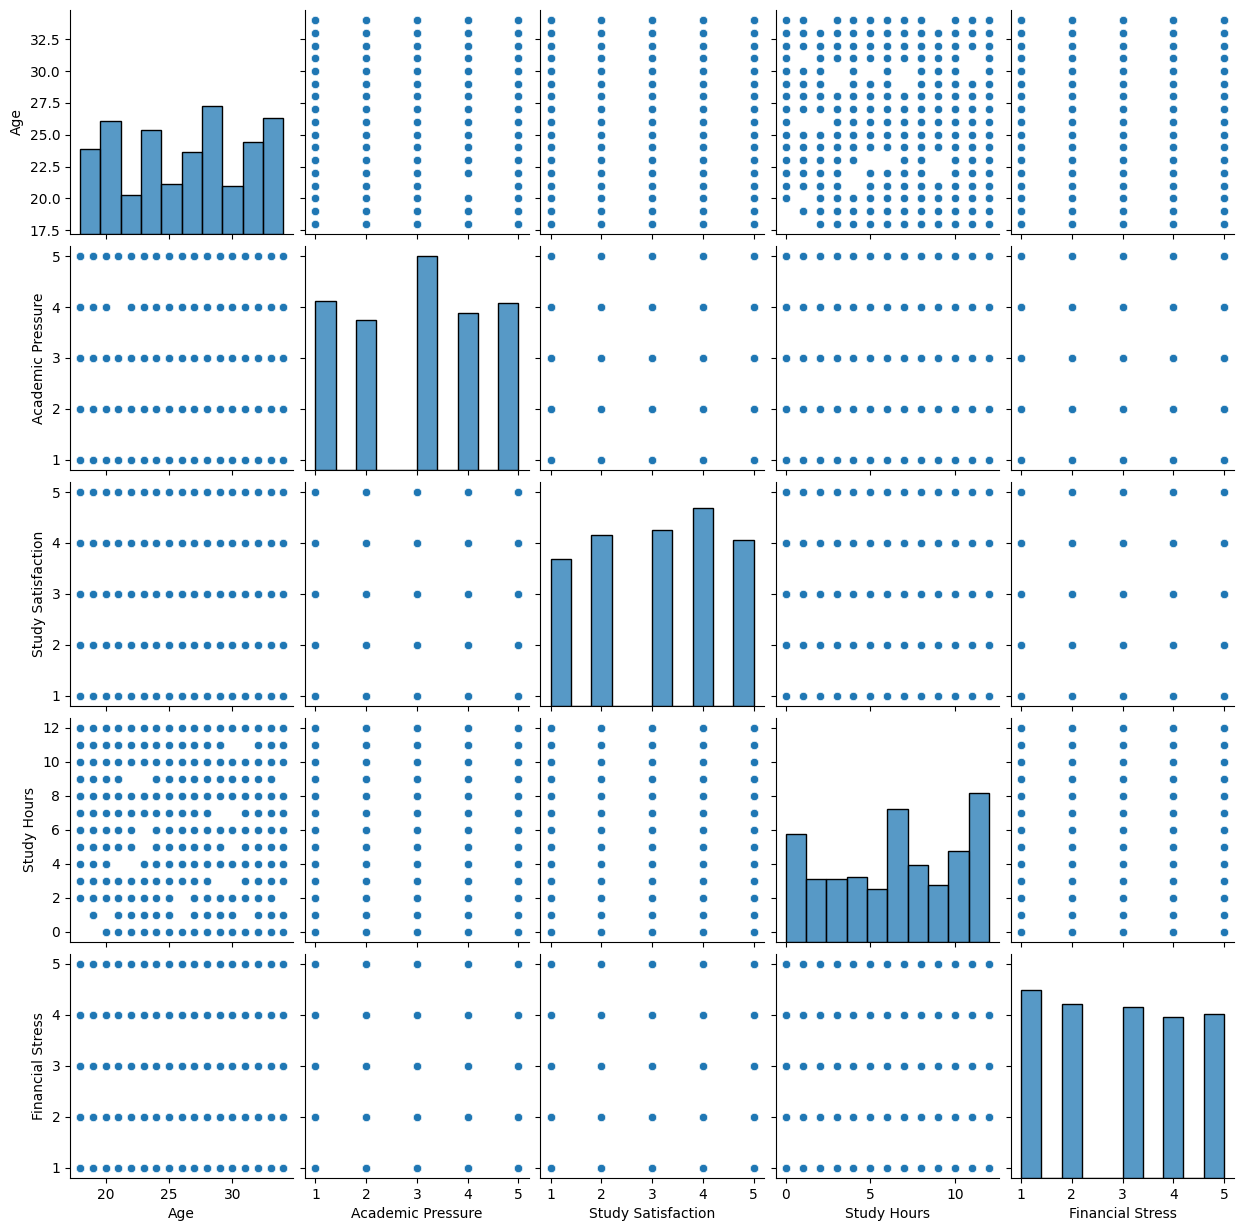

In [12]:
sns.pairplot(df)

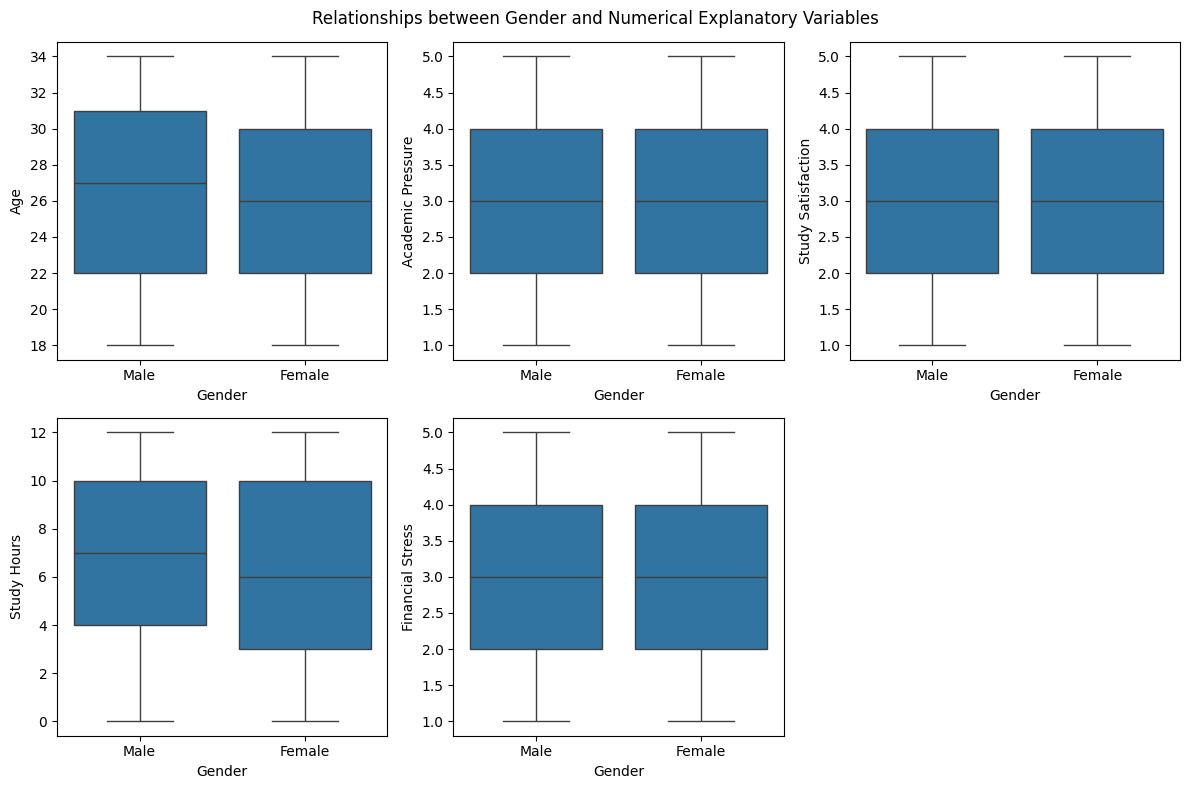

In [13]:
plt.figure(figsize=(12,8))
plt.suptitle('Relationships between Gender and Numerical Explanatory Variables')
n = 1
for col in numerical_exp_vars:
    plt.subplot(2,3,n)
    sns.boxplot(data=df, x='Gender', y=col)
    n+=1

plt.tight_layout()
plt.show()

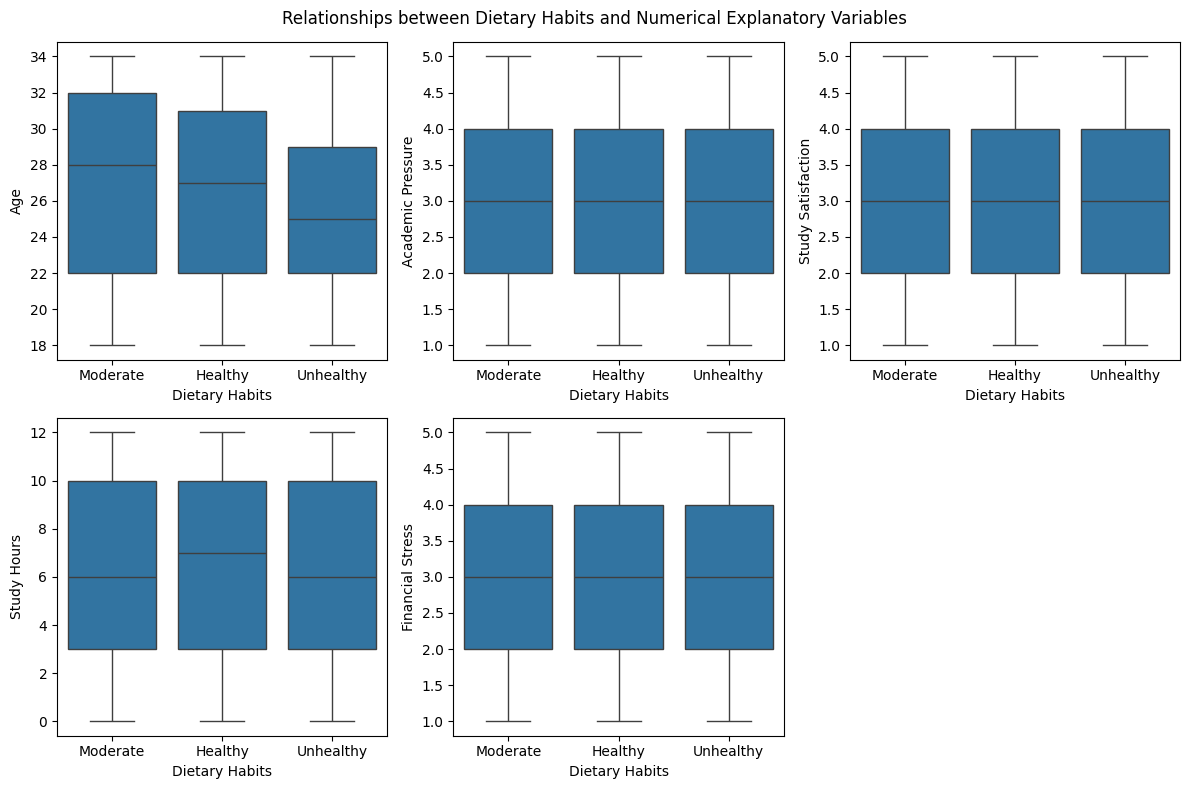

In [14]:
plt.figure(figsize=(12,8))
plt.suptitle('Relationships between Dietary Habits and Numerical Explanatory Variables')
n=1
for col in numerical_exp_vars:
    plt.subplot(2,3,n)
    sns.boxplot(data=df, x='Dietary Habits', y=col)
    n+=1

plt.tight_layout()
plt.show()

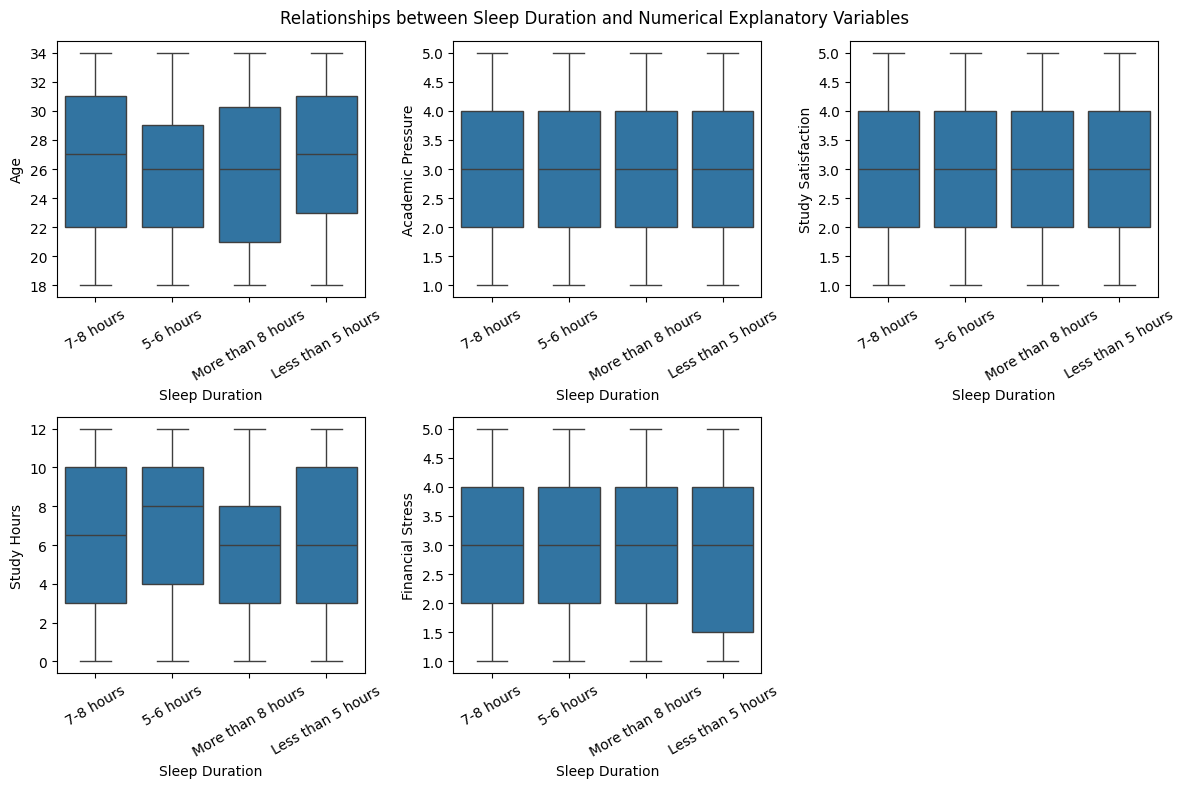

In [15]:
plt.figure(figsize=(12,8))
plt.suptitle('Relationships between Sleep Duration and Numerical Explanatory Variables')
n=1
for col in numerical_exp_vars:
    plt.subplot(2,3,n)
    sns.boxplot(data=df, x='Sleep Duration', y=col)
    plt.xticks(rotation=30)
    n+=1

plt.tight_layout()
plt.show()

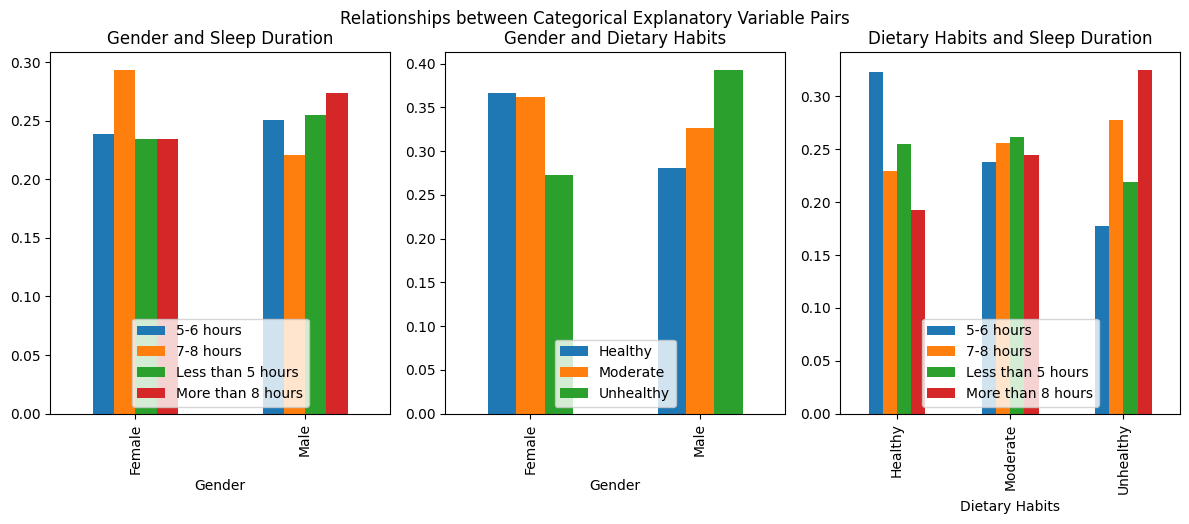

In [16]:
plt.figure(figsize=(12,14))
plt.suptitle('Relationships between Categorical Explanatory Variable Pairs')
n = 1
categorical_exp_vars_copy = categorical_exp_vars[:]
for x in categorical_exp_vars_copy:
    for y in categorical_exp_vars_copy:
        if x != y:
            ax = plt.subplot(3,3,n)
            temp = pd.crosstab(df[x], df[y], normalize='index')
            temp.plot.bar(ax=ax)
            ax.set_title(f'{x} and {y}')
            ax.legend(loc='lower center')
            n+=1
    categorical_exp_vars_copy.remove(x)

plt.tight_layout()
plt.show()

In [17]:
df_copy = df
df_copy['Depression'] = df['Depression'].replace({'Yes':1, 'No':0})

/var/folders/rh/wqc_6lmn2w38fh08k7x8fnlc0000gn/T/ipykernel_98528/962715694.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['Depression'] = df['Depression'].replace({'Yes':1, 'No':0})


As we look for interaction, most numerical and categorical explanatory variable pairs show little evidence of interaction as the slopes seem to be similar in the lmplot visualizations. However, some numerical variables showed slight interaction with the Sleep Duration categorical variable. While these patterns weren't strong enough to include interaction terms in the final models, they may be worth exploring further in future analyses.

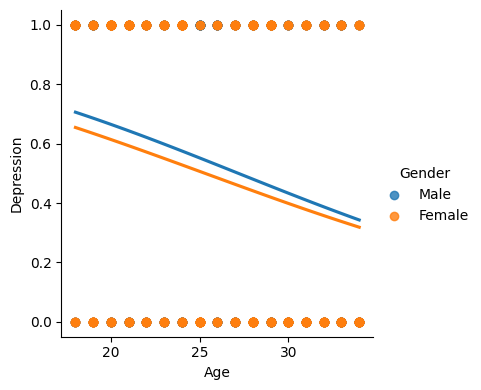

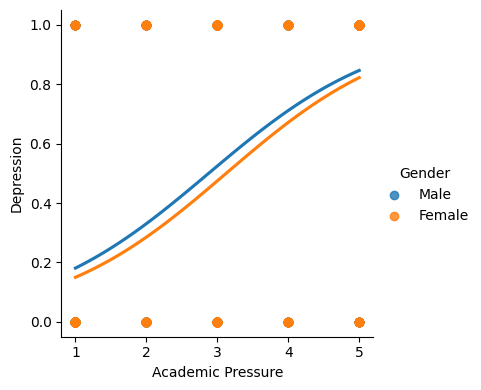

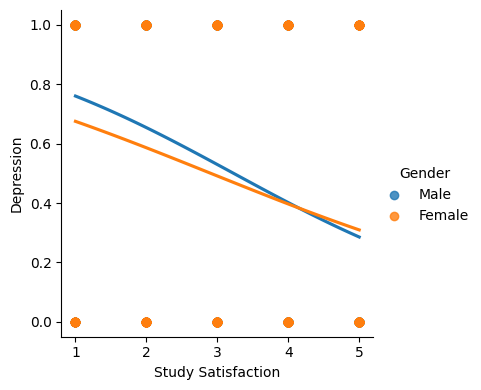

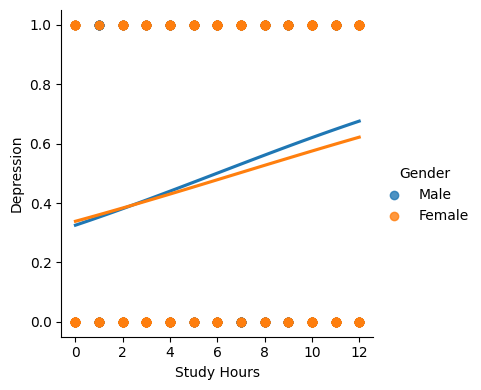

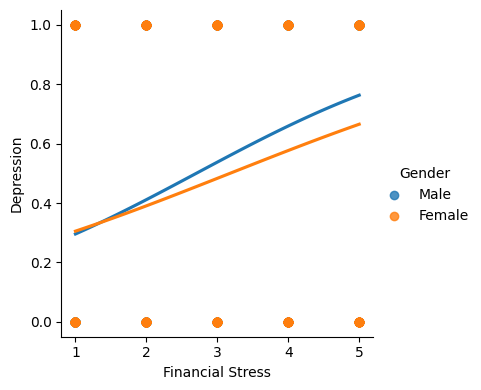

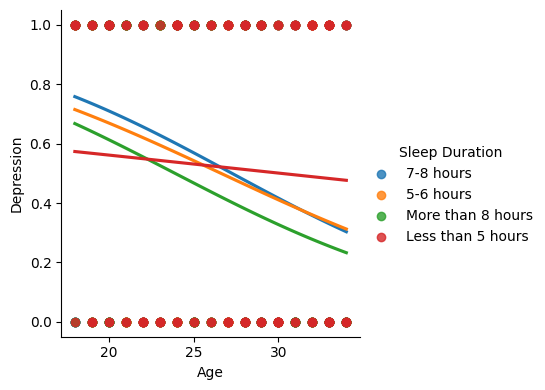

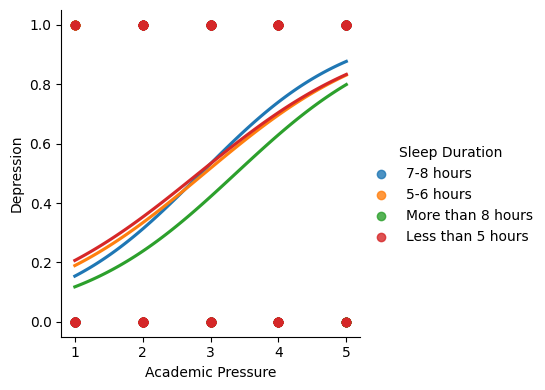

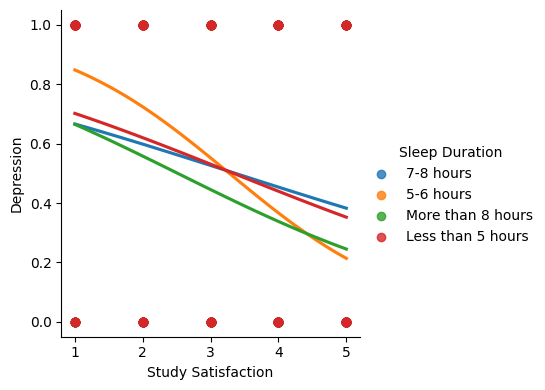

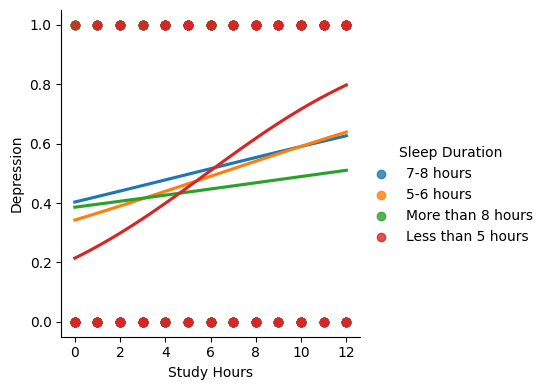

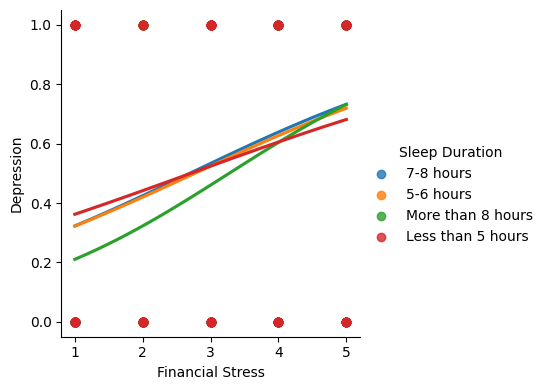

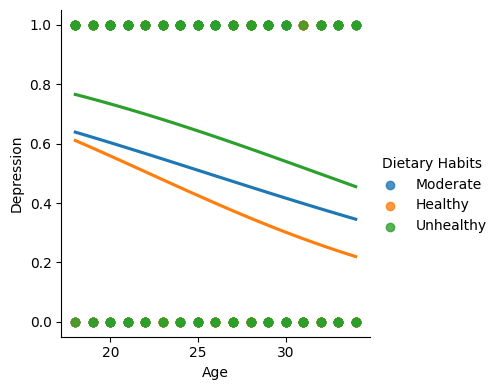

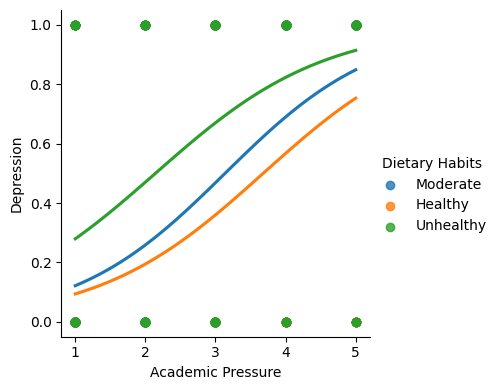

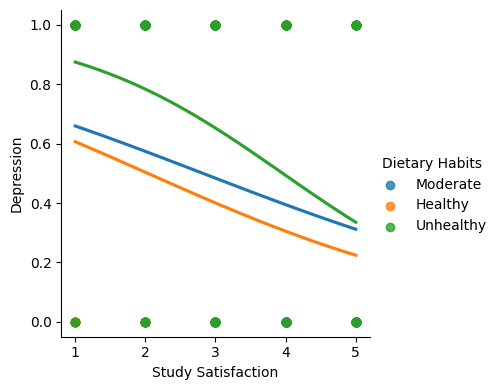

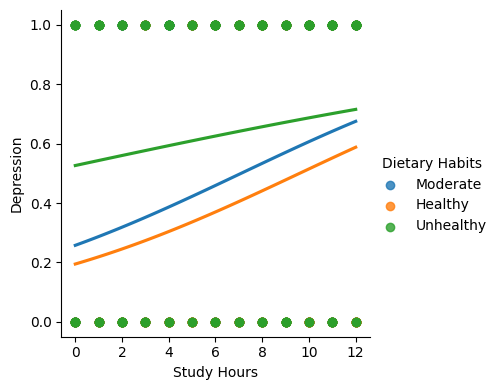

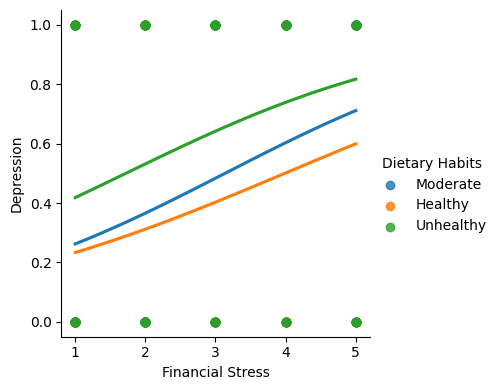

In [18]:
for col_cat in categorical_exp_vars:
    for col_num in numerical_exp_vars:
        sns.lmplot(x=col_num, y="Depression", hue=col_cat, data=df_copy, logistic=True, ci=False, height=4, aspect=1)

## 5. Model Data Preprocessing

In [19]:
df['Depression'] = df['Depression'].replace({'Yes':1, 'No':0})
df

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Study Hours,Financial Stress,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,9,2,0
1,Male,28,4.0,5.0,5-6 hours,Healthy,7,1,0
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,10,4,1
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,7,2,0
4,Female,31,1.0,5.0,More than 8 hours,Healthy,4,2,0
...,...,...,...,...,...,...,...,...,...
497,Male,26,5.0,2.0,More than 8 hours,Unhealthy,8,3,1
498,Male,24,2.0,1.0,Less than 5 hours,Unhealthy,8,5,1
499,Female,23,3.0,5.0,5-6 hours,Healthy,1,5,0
500,Male,33,4.0,4.0,More than 8 hours,Healthy,8,1,0


In [20]:
feature_matrix = df.drop(['Depression'], axis=1)
feature_matrix

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Study Hours,Financial Stress
0,Male,28,2.0,4.0,7-8 hours,Moderate,9,2
1,Male,28,4.0,5.0,5-6 hours,Healthy,7,1
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,10,4
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,7,2
4,Female,31,1.0,5.0,More than 8 hours,Healthy,4,2
...,...,...,...,...,...,...,...,...
497,Male,26,5.0,2.0,More than 8 hours,Unhealthy,8,3
498,Male,24,2.0,1.0,Less than 5 hours,Unhealthy,8,5
499,Female,23,3.0,5.0,5-6 hours,Healthy,1,5
500,Male,33,4.0,4.0,More than 8 hours,Healthy,8,1


In [21]:
target_array = df['Depression']
target_array

0      0
1      0
2      1
3      0
4      0
      ..
497    1
498    1
499    0
500    0
501    1
Name: Depression, Length: 502, dtype: int64

In [22]:
numerical_list = []
for i in feature_matrix.columns:
    if feature_matrix[i].dtype == 'int64' or feature_matrix[i].dtype == 'float64':
        numerical_list.append(i)
numerical_list

['Age',
 'Academic Pressure',
 'Study Satisfaction',
 'Study Hours',
 'Financial Stress']

In [23]:
scaler = StandardScaler()
feature_matrix[numerical_list] = scaler.fit_transform(feature_matrix[numerical_list])
feature_matrix

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Study Hours,Financial Stress
0,Male,0.359587,-0.723007,0.673631,7-8 hours,Moderate,0.694256,-0.652055
1,Male,0.359587,0.717269,1.402429,5-6 hours,Healthy,0.159311,-1.354484
2,Male,-0.253706,-1.443146,-0.055168,5-6 hours,Unhealthy,0.961728,0.752802
3,Male,-0.662569,-1.443146,0.673631,More than 8 hours,Unhealthy,0.159311,-0.652055
4,Female,0.972881,-1.443146,1.402429,More than 8 hours,Healthy,-0.643106,-0.652055
...,...,...,...,...,...,...,...,...
497,Male,-0.049275,1.437408,-0.783967,More than 8 hours,Unhealthy,0.426784,0.050373
498,Male,-0.458138,-0.723007,-1.512765,Less than 5 hours,Unhealthy,0.426784,1.455230
499,Female,-0.662569,-0.002869,1.402429,5-6 hours,Healthy,-1.445523,1.455230
500,Male,1.381743,0.717269,0.673631,More than 8 hours,Healthy,0.426784,-1.354484


In [24]:
feature_matrix = pd.get_dummies(data=feature_matrix, drop_first=True, dtype=int)
feature_matrix

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress,Gender_Male,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Dietary Habits_Moderate,Dietary Habits_Unhealthy
0,0.359587,-0.723007,0.673631,0.694256,-0.652055,1,1,0,0,1,0
1,0.359587,0.717269,1.402429,0.159311,-1.354484,1,0,0,0,0,0
2,-0.253706,-1.443146,-0.055168,0.961728,0.752802,1,0,0,0,0,1
3,-0.662569,-1.443146,0.673631,0.159311,-0.652055,1,0,0,1,0,1
4,0.972881,-1.443146,1.402429,-0.643106,-0.652055,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
497,-0.049275,1.437408,-0.783967,0.426784,0.050373,1,0,0,1,0,1
498,-0.458138,-0.723007,-1.512765,0.426784,1.455230,1,0,1,0,0,1
499,-0.662569,-0.002869,1.402429,-1.445523,1.455230,0,0,0,0,0,0
500,1.381743,0.717269,0.673631,0.426784,-1.354484,1,0,0,1,0,0


## 6. Feature Selection with K-Fold Cross-Validation

We are using a Lasso Regression model for regularization because it provides clearer coefficient interpretations and helps identify variables that do not contribute significantly to predictive power at a given value of λ (lambda). Ideally, we want this model to be used for predicting the depression status of new students. To collect the necessary data, students would need to complete a survey. By using Lasso, any variables that are deemed unimportant (those with coefficients shrunk to zero) can be removed, thereby reducing the number of survey questions. This would make the survey process faster and more efficient. Although a potential downside of Lasso is that it requires more computational time compared to Ridge regression, we are willing to accept this cost in exchange for the time saved during data collection.

In [25]:
# k-fold
cross_val = KFold(n_splits=5, shuffle=True, random_state=207)

In [26]:
data=[]

# Non-regularized: Lasso with lambda 0
non_reg_mod = LogisticRegression(max_iter=1000)
test_fold_AUC = cross_val_score(non_reg_mod, feature_matrix, target_array, cv=cross_val, scoring='roc_auc')
data.append({'Lambda':0, 'AUC mean':test_fold_AUC.mean()})

# Lasso with lambda > 0
for Lambda in np.arange(0.005, 1, 0.005):
    lasso_mod = LogisticRegression('l1', solver='liblinear', max_iter=1000, C=1/Lambda)
    test_fold_AUC = cross_val_score(lasso_mod, feature_matrix, target_array, cv=cross_val, scoring='roc_auc')
    data.append({'Lambda':Lambda, 'AUC mean':test_fold_AUC.mean()})

results = pd.DataFrame(data)
results

,Lambda,AUC mean
0,0.000,0.904245
1,0.005,0.903932
2,0.010,0.904013
3,0.015,0.904091
4,0.020,0.904091
...,...,...
195,0.975,0.902822
196,0.980,0.902822
197,0.985,0.902900
198,0.990,0.902821


Text(0.5, 1.0, 'Mean AUC scores of LASSO regression models')

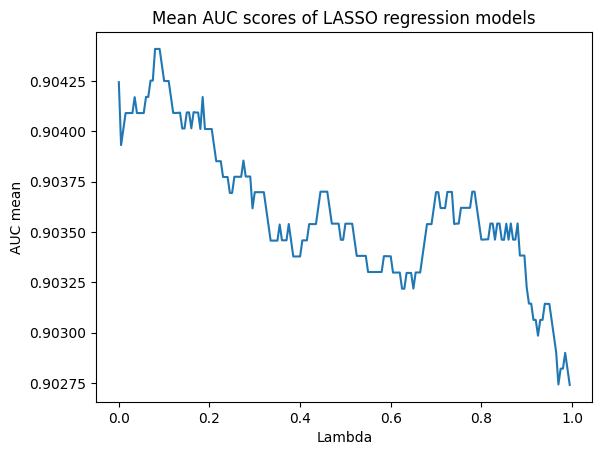

In [27]:
sns.lineplot(data=results, x='Lambda', y='AUC mean')
plt.title('Mean AUC scores of LASSO regression models')

In [28]:
results.nlargest(1, 'AUC mean')

,Lambda,AUC mean
16,0.08,0.90441


## 7. Best Model Discussion

#### Train-Test Split

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=207)
df_test.shape[0] / df.shape[0]

# Preprocessing
df_train[numerical_list] = scaler.fit_transform(df_train[numerical_list])
df_test[numerical_list] = scaler.transform(df_test[numerical_list])

X_train = pd.get_dummies(data=df_train, drop_first=True, dtype=int)
X_test = pd.get_dummies(data=df_test, drop_first=True, dtype=int)

X_train = X_train.drop(columns=["Depression"])
y_train = df_train["Depression"]

X_test = X_test.drop(columns=["Depression"])
y_test = df_test["Depression"]


#### Features Selection

Here we are fitting our lasso selection model to see if any slopes are zeroed out when the lambda value is 0.08.

In [30]:
# Instantiating Lasso logistic regression model with lambda value of 0.08
lasso_mod = LogisticRegression('l1', solver= 'liblinear', max_iter=1000, C = 1/0.08)

# Fitting the model with training features matrix and target array
lasso_mod.fit(X_train, y_train)

df_slopes = pd.DataFrame({'lasso_mod_08': lasso_mod.coef_.flatten()}, index=X_train.columns)
df_slopes


,lasso_mod_08
Age,-0.873416
Academic Pressure,1.589910
Study Satisfaction,-1.055146
Study Hours,0.776728
Financial Stress,1.004337
Gender_Male,0.013291
Sleep Duration_7-8 hours,0.043054
Sleep Duration_Less than 5 hours,0.359646
Sleep Duration_More than 8 hours,-0.393840
Dietary Habits_Moderate,0.773781


In [31]:
lasso_mod.intercept_

array([-0.80399179])

$$

\hat{p} = 

\frac{1}
{
1+ \exp{
\left(
-
\begin{align*}

&- 0.8045 \\

&- 0.8734 \times \text{Age} \\

&+ 1.5899 \times \text{Academic Pressure} \\

&- 1.0552 \times \text{Study Satisfaction} \\

&+ 0.7767 \times \text{Study Hours} \\

&+ 1.0044 \times \text{Financial Stress} \\

&+ 0.0133 \times \text{Gender}_{\text{Male}} \\

&+ 0.0434 \times \text{Sleep Duration}_{\text{7-8 hours}} \\

&+ 0.3600 \times \text{Sleep Duration}_{\text{Less than 5 hours}} \\

&- 0.3935 \times \text{Sleep Duration}_{\text{More than 8 hours}} \\

&+ 0.7738 \times \text{Dietary Habits}_{\text{Moderate}} \\

&+ 1.8670 \times \text{Dietary Habits}_{\text{Unhealthy}} 

\end{align*}


\right)    
}

}

$$

#### Issue with Multicollinearity

In [32]:
df_train.corr(numeric_only=True)

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress,Depression
Age,1.000000,0.060588,0.015544,0.073252,-0.122251,-0.218707
Academic Pressure,0.060588,1.000000,-0.106780,0.067749,0.023966,0.441851
Study Satisfaction,0.015544,-0.106780,1.000000,-0.022579,-0.036052,-0.316291
Study Hours,0.073252,0.067749,-0.022579,1.000000,0.040387,0.206584
Financial Stress,-0.122251,0.023966,-0.036052,0.040387,1.000000,0.297101
Depression,-0.218707,0.441851,-0.316291,0.206584,0.297101,1.000000


The remaining explanatory variables do not have an issue with multicollinearity because the correlations between the remaining variables always have a correlation that is less than 0.7 with each other.

#### Strength of Relationship & Possibility of Overfitting

We are able to interpret the magnitudes of the slopes as indicating how important the corresponding explanatory variable is when it comes to predicting our response variable, because the values in the features matrices have by standard scaled, which means that they have the same standard deviation of 1. So that the slopes magnitudes could be used to determine the importance of the variables, and the slopes that have a larger magnitude would be more important. Out of the remaining explanatory variables, "Dietary Habits" appears to have the biggest slope value, hence it is the most important variable.

The fact that this is our "best model" suggests that none of our original explanatory variables were overfitting the model, because there aren't really any variables that were zeroed out; all of our variables are meaningful to the model.

#### ROC Curve

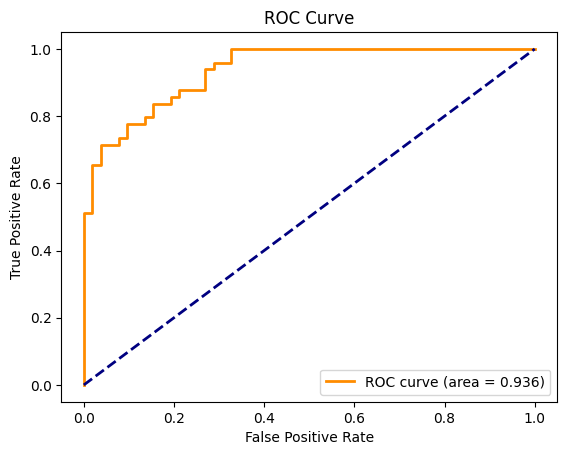

In [33]:
# ROC curve for best lasso model
y_pred = lasso_mod.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
auc = roc_auc_score(y_true=y_test,y_score=y_pred)
def plot_roc(fpr, tpr, auc, lw =2):
   plt.plot(fpr,tpr,color = 'darkorange',lw = lw,
            label = 'ROC curve (area = '+str(round(auc,3))+')')
   plt.plot([0,1],[0,1],color = 'navy',lw = lw, linestyle = '--')
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate")
   plt.title("ROC Curve")
   plt.legend(loc="lower right")
   plt.show()
plot_roc(fprs,tprs,auc)


In [34]:
auc

np.float64(0.9364207221350078)

The model did a good job because the ROC curve has an AUC score of 0.94, which means it can seperate the two classes fairly well. Therefore, our dataset would classify the observations well in general.

In [35]:
roc_df = pd.DataFrame({
    'threshold': thresholds,
    'fpr': fprs,
    'tpr': tprs
})
roc_df

,threshold,fpr,tpr
0,inf,0.000000,0.000000
1,0.997507,0.000000,0.020408
2,0.860197,0.000000,0.510204
3,0.833378,0.019231,0.510204
4,0.745453,0.019231,0.653061
5,0.698897,0.038462,0.653061
6,0.670220,0.038462,0.714286
7,0.651197,0.076923,0.714286
8,0.637619,0.076923,0.734694
9,0.637161,0.096154,0.734694


The true positive rate in our research is the rate that the depressed students are correctly indentified; the false positive rate in our research is the rate that a undepressed student is indentified as depressed. In our research, we want to maximize our true positive rate, because it is much worse to miss a truly depressed student (false negative) than it is to bother a healthy student with an extra conversation (false positive). Hence, it's more resonable to choose a threshold of 0.231646, while the tpr=1.0 is perfect and the fpr=0.326923 is still kept at a moderate level.

## 8. Additional Analysis/Insight

#### Heatmap Analysis

To further explore the relationships between the variables in our dataset, we can create a correlation heatmap. Since our dataset consists largely of discrete numerical variables (such as Academic Pressure, Study Satisfaction, and Financial Stress) and the numerical variables are the ones that are still left in our final model, clustering methods like K-Means were less appropriate for uncovering meaningful patterns. By using heatmaps, we can examine correlation and identify which predictors are most strongly associated with Depression, and assess whether the variables we selected for our logistic regression model are justified based on their relationships. This helps reinforce the findings of our predictive model and offers deeper insights into which student experiences are most linked to mental health outcomes.

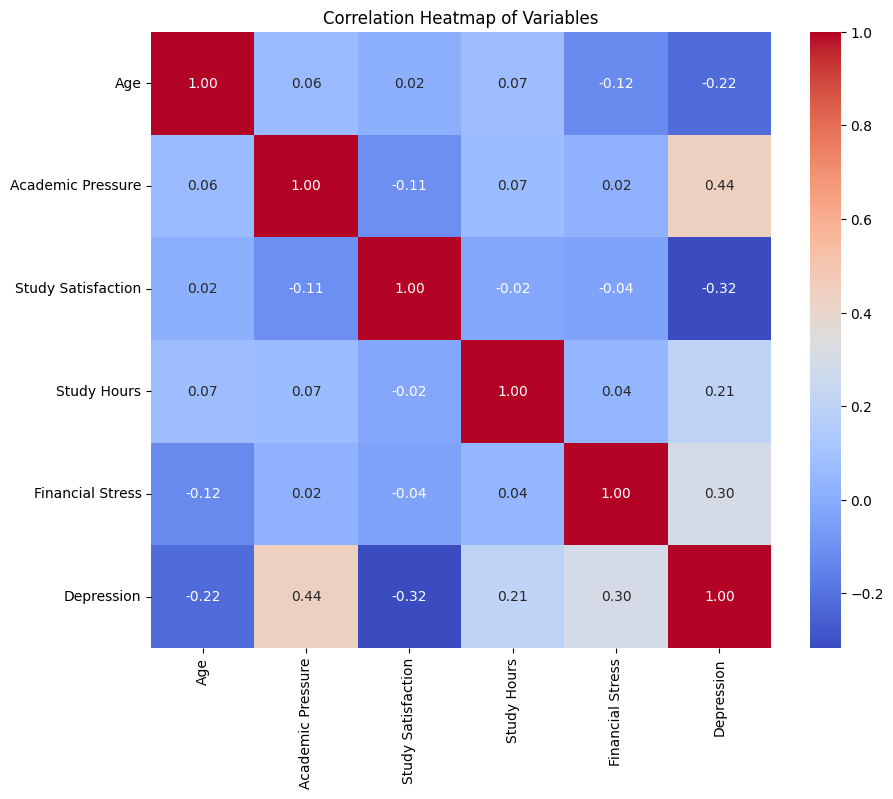

In [36]:
corr = df_train.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.show()

From the results in the heatmap, we can further assess whether or not our variables are related to Depression in the way that are meant to be. For example, the correlation between Academic Pressure and Depression is 0.44, which is positive and moderate; this makes sense because having more Academic Pressure would definitely increase the probability of Depression. In contrast, the correlation between Study Satisfaction and Depression is -0.32, which is negative and moderate; this also makes sense because being more satisfied with your study would definitely make you less likely to be depressed. These findings are consistent with the predictors selected for our logistic regression model and further validate the focus of our mental health screening approach.

## 9. Conclusion

Based on our prior analysis, we would recommend our best model to be used by teachers and students for educational purpose and preliminary assessment. Since our final AUC score is 0.94, which is high, this indicates that the model is very effective and helpful in distinguishing between students who are likely to experience depression and those who are not. This high level of accuracy suggests that the model could be a useful tool for early identification and support to our potential users.

We do not know for sure that our chosen best model yields the highest AUC score. Although our model achieves a strong average test AUC of 0.94, it’s possible that alternative modeling approaches or techniques lead to better performance. It's possible that the lambda value that brings the highest AUC score appears between the two lambda values we've tested. Also, we should use Ridge regression model and Elastic Net regression model to improve our analysis, which apply different forms of regularizations that can help handle multicollinearity among explanatory variables and prevent overfitting. It might give us different results that we want to take into account for our final model and conclusions.

A shortcoming of our analysis is that the infromation of our dataset might not be objective enough. Since the participants answered Yes/No questions and the rating questions by themselves instead of standardized evaluation process, the data we use for training the model might not reflect their true mental status strictly and authentically, thus might affecting its availability and appropriation when new users are utilizing our results as a metric for evaluation. In addition, the analysis is only based on finite samples and is not evaluated by any medical institutions. It cannot be used as a professional metric or indicator. If users feel like they are under depression, they would like to go to medical institutions and get professional diagnosis from doctors.

For our future work, we can include more types of feature selection, such as Ridge regression, Elastic Net regression, and forward/backward algorithms. Incorporating different feature selection methods will give us more well-rounded and complete insights, helping us build a more confident and supportive analysis.

## References

* American Academy of Pediatrics. (2022, November 15). Supporting students with depression in school. Home. https://www.aap.org/en/patient-care/school-health/mental-health-in-schools/supporting-students-with-depression-in-school/?srsltid=AfmBOorhCOW_Vbe3TI7HiNoWkdGVHB6xw6wE6JGoNaSougkQo2lSi97r 
* Lochrie, A. S. (Ed.). (2022, April). Depression Factsheet (for Schools) (for parents) | nemours kidshealth. KidsHealth. https://kidshealth.org/en/parents/depression-factsheet.html